### Imports

In [1]:
import os
import sys
import cv2
import json
import pathlib
import numpy as np
from glob import glob
from collections import Counter
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

In [2]:
import warnings
warnings.filterwarnings("ignore")

# mAP (Mean Average Precision) metric

In [3]:
def intersection_over_union(boxes_gt, boxes_pred):
    epsilon = 1e-6
    
    box1_x1 = boxes_gt[0]
    box1_y1 = boxes_gt[1]
    box1_x2 = boxes_gt[2]
    box1_y2 = boxes_gt[3]
    
    box2_x1 = boxes_pred[0]
    box2_y1 = boxes_pred[1]
    box2_x2 = boxes_pred[2]
    box2_y2 = boxes_pred[3]
    
    box1_area = abs((box1_x2 - box1_x1) * (box1_y1 - box1_y2))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y1 - box2_y2))
    
    x1 = max(box1_x1, box2_x1)
    y1 = max(box1_y1, box2_y1)
    x2 = min(box1_x2, box2_x2)
    y2 = min(box1_y2, box2_y2)
    
    intersection = (x2 - x1) * (y2 - y1)
    union = box1_area + box2_area - intersection
    
    iou = intersection / (union + epsilon)
    
    return iou


def mean_average_precision(gts, preds, iou_threshold=0.5, classes=[1,2,5,7]):
    
    average_precisions = []
    epsilon = 1e-6
    
    
    for c in classes:
        detections = []
        ground_truths = []
        
        for detection in preds:
            if detection[1] == c:  # class label
                detections.append(detection)
                
        for true in gts:
            if true[1] == c:  # class label
                ground_truths.append(true)
        
        # amount_bboxes = [{0:16}, {1,17}, ...]
        amount_bboxes = Counter([gt[0] for gt in ground_truths]) 
        
        # amount_bboxes = [{0:array[0,0,0...]}, {1,array[0,0,0,...]}, ...]
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = np.zeros(val)
            
        detections.sort(key=lambda x: x[2], reverse=True)
        
        TP = np.zeros(len(detections))
        FP = np.zeros(len(detections))
        total_true_bboxes = len(ground_truths)
        
        for detection_idx, detection in enumerate(detections):
            groung_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]
            
            num_gts = len(groung_truth_img)
            best_iou = 0
            
            for idx, gt in enumerate(groung_truth_img):
                iou = intersection_over_union(detection[3:], gt[2:])
                
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx
            
            if best_iou > iou_threshold:
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] == 1
                else:
                    FP[detection_idx] = 1
            else:
                FP[detection_idx] = 1
                
        # e.g cumsum := [1, 1, 0, 1, 0] -> [1, 2, 2, 3, 3] 
        TP_cumsum = np.cumsum(TP, axis=0)
        FP_cumsum = np.cumsum(FP, axis=0)
        
        recalls =  TP_cumsum / (total_true_bboxes + epsilon)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum + epsilon)
        
        recalls = np.concatenate((np.zeros(1), recalls))   # x- axis
        precisions = np.concatenate((np.ones(1), precisions))  # y- axis  
        
        average_precisions.append(np.trapz(y=precisions, x=recalls))
        
    mAP = sum(average_precisions) / len(average_precisions)
    
    return mAP

In [4]:
def get_mAP_dict(mAPs):
    iou_thresholds = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
    mAP_dict = {}
    for idx, iou_threshold in enumerate(iou_thresholds):
        mAP_dict[f'mAP_{iou_threshold}'] = mAPs[idx]
    
    mAP_average = sum(mAPs)/ len(mAPs)
    mAP_dict['mAP_average'] = mAP_average
    return mAP_dict

### Read images path

In [5]:
images_path = os.path.join(os.getcwd(), 'images')
images = glob(os.path.join(images_path, '*.jpg'))
len(images)

402

# ---------------------------------------------------------------------------------------------------------------

# YOLOv5 Evaluation

### Read class_list file

In [6]:
class_label_path = os.path.join(os.getcwd(), 'class_lists', 'labelled_class_list.txt')
with open(class_label_path, 'r') as f:
    class_list = [line.rstrip() for line in f]

class_labels_dict = {k:v for k, v in enumerate(class_list)}  ###List to dict
class_labels_dict

{0: 'bicycle', 1: 'bike', 2: 'bus', 3: 'car', 4: 'cng', 5: 'truck'}

In [7]:
yolo_classes_path = os.path.join(os.getcwd(), 'class_lists', 'yolo_classes.txt')
with open(yolo_classes_path, 'r') as f:
    yolo_class_dict = json.loads(f.read())
    
yolo_class_dict

{'all': None,
 'person': 0,
 'bicycle': 1,
 'car': 2,
 'motorcycle': 3,
 'airplane': 4,
 'bus': 5,
 'train': 6,
 'truck': 7,
 'boat': 8,
 'traffic light': 9,
 'fire hydrant': 10,
 'stop sign': 11,
 'parking meter': 12,
 'bench': 13,
 'bird': 14,
 'cat': 15,
 'dog': 16,
 'horse': 17,
 'sheep': 18,
 'cow': 19,
 'elephant': 20,
 'bear': 21,
 'zebra': 22,
 'giraffe': 23,
 'backpack': 24,
 'umbrella': 25,
 'handbag': 26,
 'tie': 27,
 'suitcase': 28,
 'frisbee': 29,
 'skis': 30,
 'snowboard': 31,
 'sports ball': 32,
 'kite': 33,
 'baseball bat': 34,
 'baseball glove': 35,
 'skateboard': 36,
 'surfboard': 37,
 'tennis racket': 38,
 'bottle': 39,
 'wine glass': 40,
 'cup': 41,
 'fork': 42,
 'knife': 43,
 'spoon': 44,
 'bowl': 45,
 'banana': 46,
 'apple': 47,
 'sandwich': 48,
 'orange': 49,
 'broccoli': 50,
 'carrot': 51,
 'hot dog': 52,
 'pizza': 53,
 'donut': 54,
 'cake': 55,
 'chair': 56,
 'couch': 57,
 'potted plant': 58,
 'bed': 59,
 'dining table': 60,
 'toilet': 61,
 'tv': 62,
 'laptop':

### Read YOLO labels

In [8]:
yolo_path = os.path.join(os.getcwd(), 'labels', 'YOLO_darknet')
yolo_files = glob(os.path.join(yolo_path, '*.txt'))
len(yolo_files)

402

In [9]:
class yolo_parser:
    def __init__(self, class_labels, yolo_classes):
        self.class_labels = class_labels
        self.yolo_classes = yolo_classes
        self.reverse_yolo_classes = {v: k for k, v in yolo_classes.items()}
        
    def read_image(self, image_path):
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        self.img = img
        return img
        
    def read_yolo(self, yolo_path):
        with open(yolo_path, 'r') as f:
            data = [line.rstrip() for line in f]
        return data
    
    def map_to_yolo_labels(self, label):
        return self.yolo_classes[self.class_labels[label]]
        
    def get_coordinates(self, image_path, yolo_path):
        '''
            Input: image path, yolo_label file path
            Output: list -> [[class_label, coordinates],...] 
                e.g. [[0, 5, 5, 10, 10])   #label, x1, y1, x2, y2
                
            Reference link: 
            https://stackoverflow.com/questions/64096953/how-to-convert-yolo-format-bounding-box-coordinates-into-opencv-format
        '''
        
        img = self.read_image(image_path)
        dh, dw, _ = img.shape
        
        data = self.read_yolo(yolo_path)
        
        result = []
        
        for dt in data:

            # Split string to float
            label, x, y, w, h = map(float, dt.split(' '))
            label = self.map_to_yolo_labels(label)
            
            # Taken from https://github.com/pjreddie/darknet/blob/810d7f797bdb2f021dbe65d2524c2ff6b8ab5c8b/src/image.c#L283-L291
            # via https://stackoverflow.com/questions/44544471/how-to-get-the-coordinates-of-the-bounding-box-in-yolo-object-detection#comment102178409_44592380
            x1 = int((x - w / 2) * dw)
            y1 = int((y - h / 2) * dh)
            x2 = int((x + w / 2) * dw)
            y2 = int((y + h / 2) * dh)
    
            if x1 < 0:
                x1 = 0
            if y1 < 0:
                y1 = 0
            if x2 > dw - 1:
                x2 = dw - 1
            if y2 > dh - 1:
                y2 = dh - 1
            
            
            result.append([label, x1, y1, x2, y2])
            
        return result
    
    def draw_bboxes(self, data):
        
        for label, x1, y1, x2, y2 in data:
            
            # draw bbox rectangle
            color = (248, 255, 6) if label < 5 else (6, 255, 31)
            thickness = 3
            cv2.rectangle(self.img, (x1, y1), (x2, y2), color, thickness)
            
            # put label text
            text = self.reverse_yolo_classes[label]
            font = cv2.FONT_HERSHEY_SIMPLEX
            origin = (x1, y1)
            fontScale = 1
            color = (255, 0, 0)
            thickness = 3
            cv2.putText(self.img, text, origin, font, fontScale, color, thickness, cv2.LINE_AA)
            
        return self.img

In [10]:
obj = yolo_parser(class_labels_dict, yolo_class_dict)

### Vizualize Ground Truth Bounding boxes

StopIteration: 

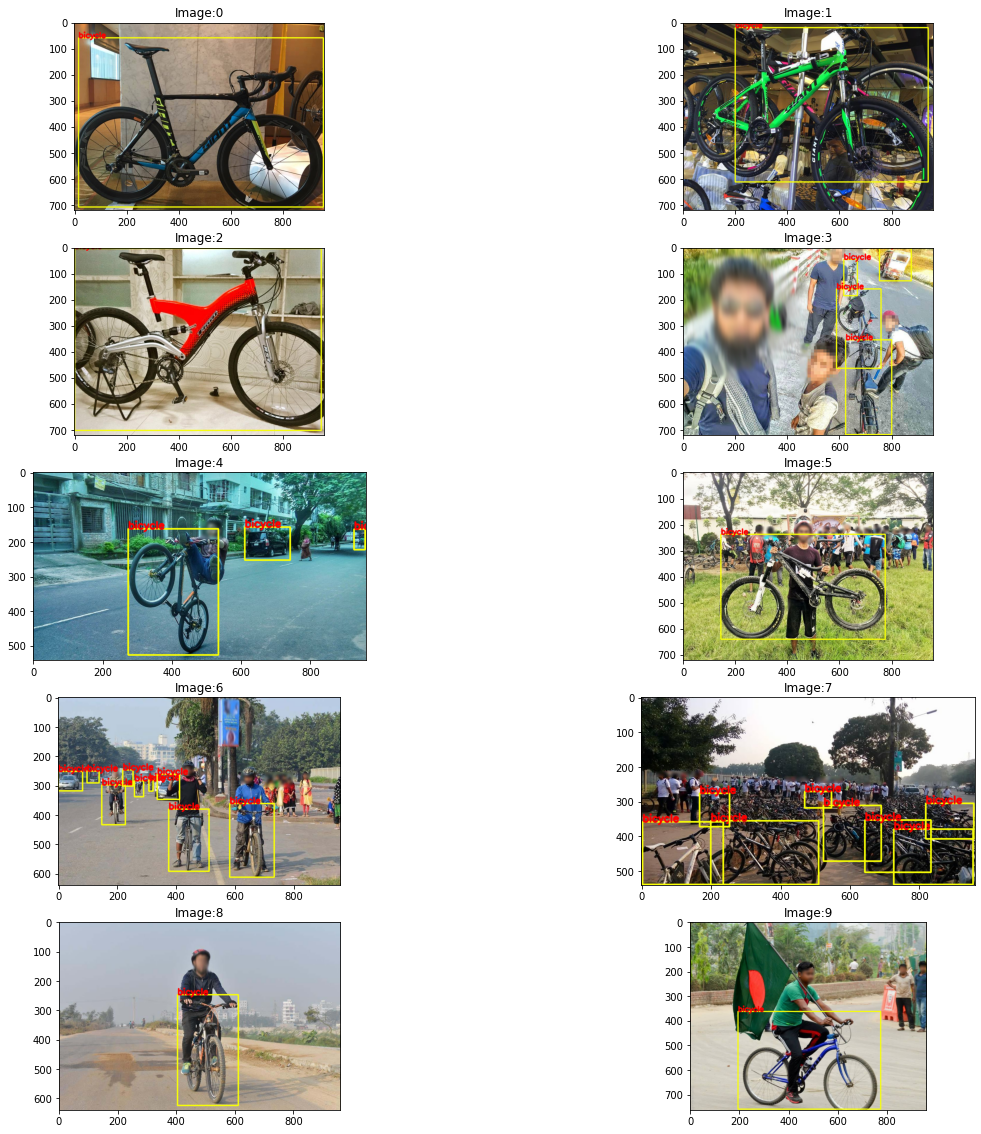

In [11]:
fig, axes = plt.subplots(5,2, figsize=(20,20))
axis_iter = iter(axes.ravel())
gts = []

for idx, (image_path, yolo_path) in enumerate(zip(images, yolo_files)):
#     print(image_path)
    
    data_gt = obj.get_coordinates(image_path, yolo_path)
    img = obj.draw_bboxes(data_gt)
    
    for gt in data_gt:
        gts.append([idx] + gt)
        
    ax = next(axis_iter)
    ax.imshow(img)
    ax.set_title('Image:'+str(idx))

In [11]:
gts

[[0, 1, 17, 60, 957, 708],
 [1, 1, 200, 21, 941, 612],
 [2, 1, 2, 5, 949, 702],
 [3, 1, 617, 47, 669, 186],
 [3, 1, 624, 355, 801, 718],
 [3, 1, 589, 160, 760, 464],
 [3, 1, 754, 0, 876, 129],
 [4, 1, 274, 163, 534, 526],
 [4, 1, 610, 158, 741, 253],
 [4, 1, 925, 164, 957, 223],
 [5, 1, 145, 238, 776, 640],
 [6, 1, 582, 361, 733, 611],
 [6, 1, 375, 380, 512, 591],
 [6, 1, 148, 298, 228, 433],
 [6, 1, 259, 284, 290, 338],
 [6, 1, 308, 281, 322, 319],
 [6, 1, 0, 252, 83, 318],
 [6, 1, 336, 262, 412, 347],
 [6, 1, 98, 251, 139, 291],
 [6, 1, 219, 247, 254, 302],
 [7, 1, 4, 358, 236, 538],
 [7, 1, 524, 311, 690, 471],
 [7, 1, 200, 355, 510, 538],
 [7, 1, 168, 276, 254, 372],
 [7, 1, 726, 379, 954, 538],
 [7, 1, 643, 353, 833, 503],
 [7, 1, 470, 271, 547, 318],
 [7, 1, 818, 305, 956, 407],
 [8, 1, 403, 247, 610, 624],
 [9, 1, 194, 362, 772, 758],
 [10, 1, 304, 0, 416, 83],
 [10, 1, 2, 3, 128, 57],
 [10, 1, 720, 58, 949, 225],
 [10, 1, 478, 47, 692, 206],
 [10, 1, 292, 118, 412, 386],
 [10, 

### Load Yolov5 model

In [12]:
import torch

In [13]:
ckpt_path = os.path.join(os.getcwd(), "yolov5s.pt")
model = torch.hub.load('ultralytics/yolov5', 'custom', path=ckpt_path)

Using cache found in C:\Users\Pc-Klinik/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2022-1-11 torch 1.10.2+cpu CPU

Fusing layers... 
Model Summary: 213 layers, 7225885 parameters, 0 gradients, 16.5 GFLOPs
Adding AutoShape... 


In [15]:
model.classes = [yolo_class_dict['bicycle'],yolo_class_dict['car'], yolo_class_dict['bus'], yolo_class_dict['truck']]
model.conf = 0.5

### Vizualize Predicted (Yolov5)  Bounding boxes

StopIteration: 

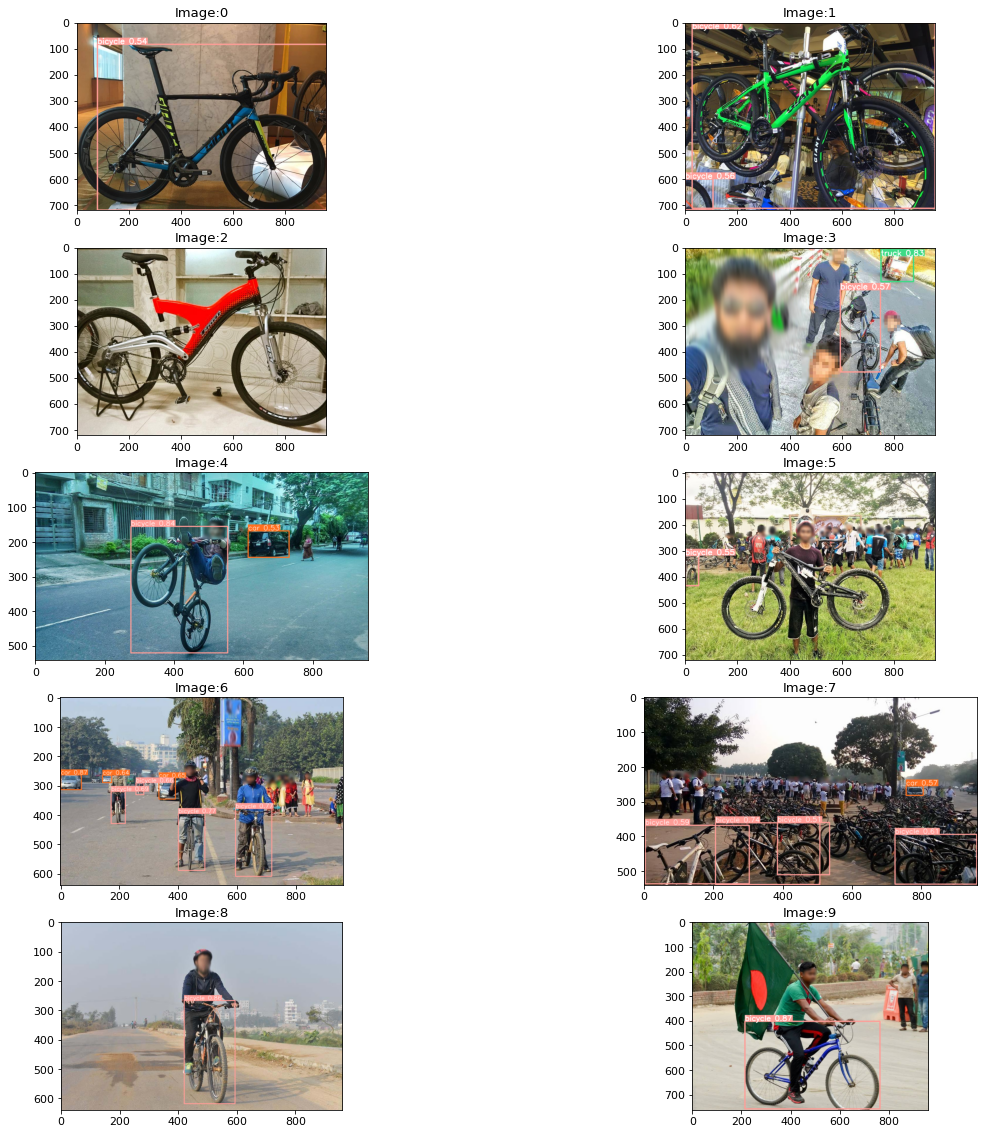

In [15]:
fig, axes = plt.subplots(5,2, figsize=(20,20))
axis_iter = iter(axes.ravel())

preds = []
mapper = lambda x, _map: int(x.cpu().numpy()) if _map == int else float(x.cpu().numpy())

for idx, (image_path, yolo_path) in enumerate(zip(images, yolo_files)):
    img = obj.read_image(image_path)
    results = model(img)
    output_img = np.squeeze(results.render())
    
    for res in results.xyxy[0]:
        label = mapper(res[5], int)
        score = mapper(res[4], float)
        x1, y1, x2, y2 = mapper(res[0], int), mapper(res[1], int), mapper(res[2], int), mapper(res[3], int)
        preds.append([idx, label, score] + [x1, y1, x2, y2])
        
    ax = next(axis_iter)
    ax.imshow(img)
    ax.set_title('Image:'+str(idx))

In [16]:
preds

[[0, 1, 0.5350297689437866, 78, 85, 960, 720],
 [1, 1, 0.6163140535354614, 27, 1, 960, 713],
 [1, 1, 0.5584439635276794, 0, 601, 107, 719],
 [3, 7, 0.8305537700653076, 752, 9, 877, 132],
 [3, 1, 0.5733985304832458, 596, 163, 750, 478],
 [4, 1, 0.8351198434829712, 276, 156, 555, 520],
 [4, 2, 0.5331816673278809, 614, 169, 732, 245],
 [5, 1, 0.5544617176055908, 0, 319, 52, 435],
 [6, 2, 0.8685622215270996, 2, 264, 72, 314],
 [6, 1, 0.773874819278717, 401, 395, 491, 588],
 [6, 1, 0.7687051296234131, 595, 378, 718, 608],
 [6, 1, 0.686586320400238, 173, 320, 221, 429],
 [6, 1, 0.6567143201828003, 257, 291, 284, 331],
 [6, 2, 0.6548221707344055, 335, 274, 391, 346],
 [6, 2, 0.6394513249397278, 144, 265, 175, 290],
 [7, 1, 0.7366899251937866, 205, 361, 505, 538],
 [7, 1, 0.613700270652771, 721, 394, 956, 537],
 [7, 1, 0.5920659303665161, 3, 368, 302, 536],
 [7, 2, 0.5671238899230957, 753, 255, 802, 282],
 [7, 1, 0.5050644278526306, 383, 360, 533, 510],
 [8, 1, 0.8624140620231628, 419, 267, 59

### Calculate mAP @ 0.5:0.05:0.95

In [22]:
'''
https://datascience.stackexchange.com/questions/16797/what-does-the-notation-map-5-95-mean

mAP@[0.5:0.05:95] -> iou_thresholds = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
'''

mAPs = []
iou_thresholds = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
for iou_threshold in iou_thresholds:
    mAP = mean_average_precision(gts, preds, iou_threshold=iou_threshold, classes=[1,2,5,7])
    mAPs.append(mAP)
    
mAP_dict = get_mAP_dict(mAPs)
mAP_dict

{'mAP_0.5': 0.11789041401429132,
 'mAP_0.55': 0.11789041401429132,
 'mAP_0.6': 0.10914487840652388,
 'mAP_0.65': 0.10914487840652388,
 'mAP_0.7': 0.10175873770601175,
 'mAP_0.75': 0.08299841525095604,
 'mAP_0.8': 0.06417512839794054,
 'mAP_0.85': 0.019310931052448414,
 'mAP_0.9': 0.0069136089283691575,
 'mAP_0.95': 0.004436131778110755,
 'mAP_average': 0.07336635379554671}

# ---------------------------------------------------------------------------------------------------------------

# FasterRCNN & SSD Evaluation

In [23]:
import tensorflow as tf

In [24]:
sys.path.append(os.path.join(os.path.abspath(os.getcwd()), 'models','research'))
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [25]:
PATH_TO_LABELS = os.path.join(os.getcwd(),'models','research','object_detection','data','mscoco_label_map.pbtxt')
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
category_index

{1: {'id': 1, 'name': 'person'},
 2: {'id': 2, 'name': 'bicycle'},
 3: {'id': 3, 'name': 'car'},
 4: {'id': 4, 'name': 'motorcycle'},
 5: {'id': 5, 'name': 'airplane'},
 6: {'id': 6, 'name': 'bus'},
 7: {'id': 7, 'name': 'train'},
 8: {'id': 8, 'name': 'truck'},
 9: {'id': 9, 'name': 'boat'},
 10: {'id': 10, 'name': 'traffic light'},
 11: {'id': 11, 'name': 'fire hydrant'},
 13: {'id': 13, 'name': 'stop sign'},
 14: {'id': 14, 'name': 'parking meter'},
 15: {'id': 15, 'name': 'bench'},
 16: {'id': 16, 'name': 'bird'},
 17: {'id': 17, 'name': 'cat'},
 18: {'id': 18, 'name': 'dog'},
 19: {'id': 19, 'name': 'horse'},
 20: {'id': 20, 'name': 'sheep'},
 21: {'id': 21, 'name': 'cow'},
 22: {'id': 22, 'name': 'elephant'},
 23: {'id': 23, 'name': 'bear'},
 24: {'id': 24, 'name': 'zebra'},
 25: {'id': 25, 'name': 'giraffe'},
 27: {'id': 27, 'name': 'backpack'},
 28: {'id': 28, 'name': 'umbrella'},
 31: {'id': 31, 'name': 'handbag'},
 32: {'id': 32, 'name': 'tie'},
 33: {'id': 33, 'name': 'suitc

In [26]:
pascal_class_dict = {v['name']: v['id'] for k,v in category_index.items()}
pascal_class_dict

{'person': 1,
 'bicycle': 2,
 'car': 3,
 'motorcycle': 4,
 'airplane': 5,
 'bus': 6,
 'train': 7,
 'truck': 8,
 'boat': 9,
 'traffic light': 10,
 'fire hydrant': 11,
 'stop sign': 13,
 'parking meter': 14,
 'bench': 15,
 'bird': 16,
 'cat': 17,
 'dog': 18,
 'horse': 19,
 'sheep': 20,
 'cow': 21,
 'elephant': 22,
 'bear': 23,
 'zebra': 24,
 'giraffe': 25,
 'backpack': 27,
 'umbrella': 28,
 'handbag': 31,
 'tie': 32,
 'suitcase': 33,
 'frisbee': 34,
 'skis': 35,
 'snowboard': 36,
 'sports ball': 37,
 'kite': 38,
 'baseball bat': 39,
 'baseball glove': 40,
 'skateboard': 41,
 'surfboard': 42,
 'tennis racket': 43,
 'bottle': 44,
 'wine glass': 46,
 'cup': 47,
 'fork': 48,
 'knife': 49,
 'spoon': 50,
 'bowl': 51,
 'banana': 52,
 'apple': 53,
 'sandwich': 54,
 'orange': 55,
 'broccoli': 56,
 'carrot': 57,
 'hot dog': 58,
 'pizza': 59,
 'donut': 60,
 'cake': 61,
 'chair': 62,
 'couch': 63,
 'potted plant': 64,
 'bed': 65,
 'dining table': 67,
 'toilet': 70,
 'tv': 72,
 'laptop': 73,
 'mouse'

In [27]:
# category index for car and truck
category_index = {k:v for k,v in category_index.items() if v['name'] == 'car' or v['name'] == 'truck' or v['name'] == 'bus'
                    or v['name'] == 'bicycle'}
category_index

{2: {'id': 2, 'name': 'bicycle'},
 3: {'id': 3, 'name': 'car'},
 6: {'id': 6, 'name': 'bus'},
 8: {'id': 8, 'name': 'truck'}}

### Read Pascal labels

In [28]:
pascal_path = os.path.join(os.getcwd(), 'labels', 'PASCAL_VOC')
pascal_files = glob(os.path.join(pascal_path, '*.xml'))
pascal_files

['C:\\Users\\Pc-Klinik\\Desktop\\Object_detection_Thesis\\Evaluation\\labels\\PASCAL_VOC\\bicycle (114).xml',
 'C:\\Users\\Pc-Klinik\\Desktop\\Object_detection_Thesis\\Evaluation\\labels\\PASCAL_VOC\\bicycle (117).xml',
 'C:\\Users\\Pc-Klinik\\Desktop\\Object_detection_Thesis\\Evaluation\\labels\\PASCAL_VOC\\bicycle (13).xml',
 'C:\\Users\\Pc-Klinik\\Desktop\\Object_detection_Thesis\\Evaluation\\labels\\PASCAL_VOC\\bicycle (133).xml',
 'C:\\Users\\Pc-Klinik\\Desktop\\Object_detection_Thesis\\Evaluation\\labels\\PASCAL_VOC\\bicycle (158).xml',
 'C:\\Users\\Pc-Klinik\\Desktop\\Object_detection_Thesis\\Evaluation\\labels\\PASCAL_VOC\\bicycle (164).xml',
 'C:\\Users\\Pc-Klinik\\Desktop\\Object_detection_Thesis\\Evaluation\\labels\\PASCAL_VOC\\bicycle (169).xml',
 'C:\\Users\\Pc-Klinik\\Desktop\\Object_detection_Thesis\\Evaluation\\labels\\PASCAL_VOC\\bicycle (171).xml',
 'C:\\Users\\Pc-Klinik\\Desktop\\Object_detection_Thesis\\Evaluation\\labels\\PASCAL_VOC\\bicycle (174).xml',
 'C:\\Users

In [29]:
class pascal_parser:
    def __init__(self, pascal_classes):
        self.pascal_classes = pascal_classes
        self.reverse_pascal_classes = {v: k for k, v in pascal_classes.items()}
        
    def read_image(self, image_path):
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        self.img = img
        return img
        
    def read_pascal(self, pascal_path):
        
        data = []
        tree = ET.parse(pascal_path)
        root = tree.getroot()
        for member in root.findall('object'):
            label = member[0].text  # string e.g 'car'
            label = self.map_to_pascal_labels(label)
            x1 = int(member[4][0].text) 
            y1 = int(member[4][1].text)
            x2 = int(member[4][2].text)
            y2 = int(member[4][3].text)
            
            data.append([label, x1, y1, x2, y2])
            
        return data
    
    def map_to_pascal_labels(self, label):
        return self.pascal_classes[label]
        
    def get_coordinates(self, image_path, pascal_path):
        '''
            Input: image path, pascal_label file path
            Output: list -> [[class_label, coordinates],...] 
                e.g. [[0, 5, 5, 10, 10])   #label, x1, y1, x2, y2
        '''
        
        img = self.read_image(image_path)
        
        data = self.read_pascal(pascal_path)
            
        return data
    
    def draw_bboxes(self, data):
        
        for label, x1, y1, x2, y2 in data:
            
            # draw bbox rectangle
            color = (248, 255, 6) if label < 5 else (6, 255, 31)
            thickness = 3
            cv2.rectangle(self.img, (x1, y1), (x2, y2), color, thickness)
            
            # put label text
            text = self.reverse_pascal_classes[label]
            font = cv2.FONT_HERSHEY_SIMPLEX
            origin = (x1, y1)
            fontScale = 1
            color = (255, 0, 0)
            thickness = 3
            cv2.putText(self.img, text, origin, font, fontScale, color, thickness, cv2.LINE_AA)
            
        return self.img

In [30]:
obj = pascal_parser(pascal_class_dict)

### Vizualize Ground Truth Bounding boxes

KeyError: 'easybike'

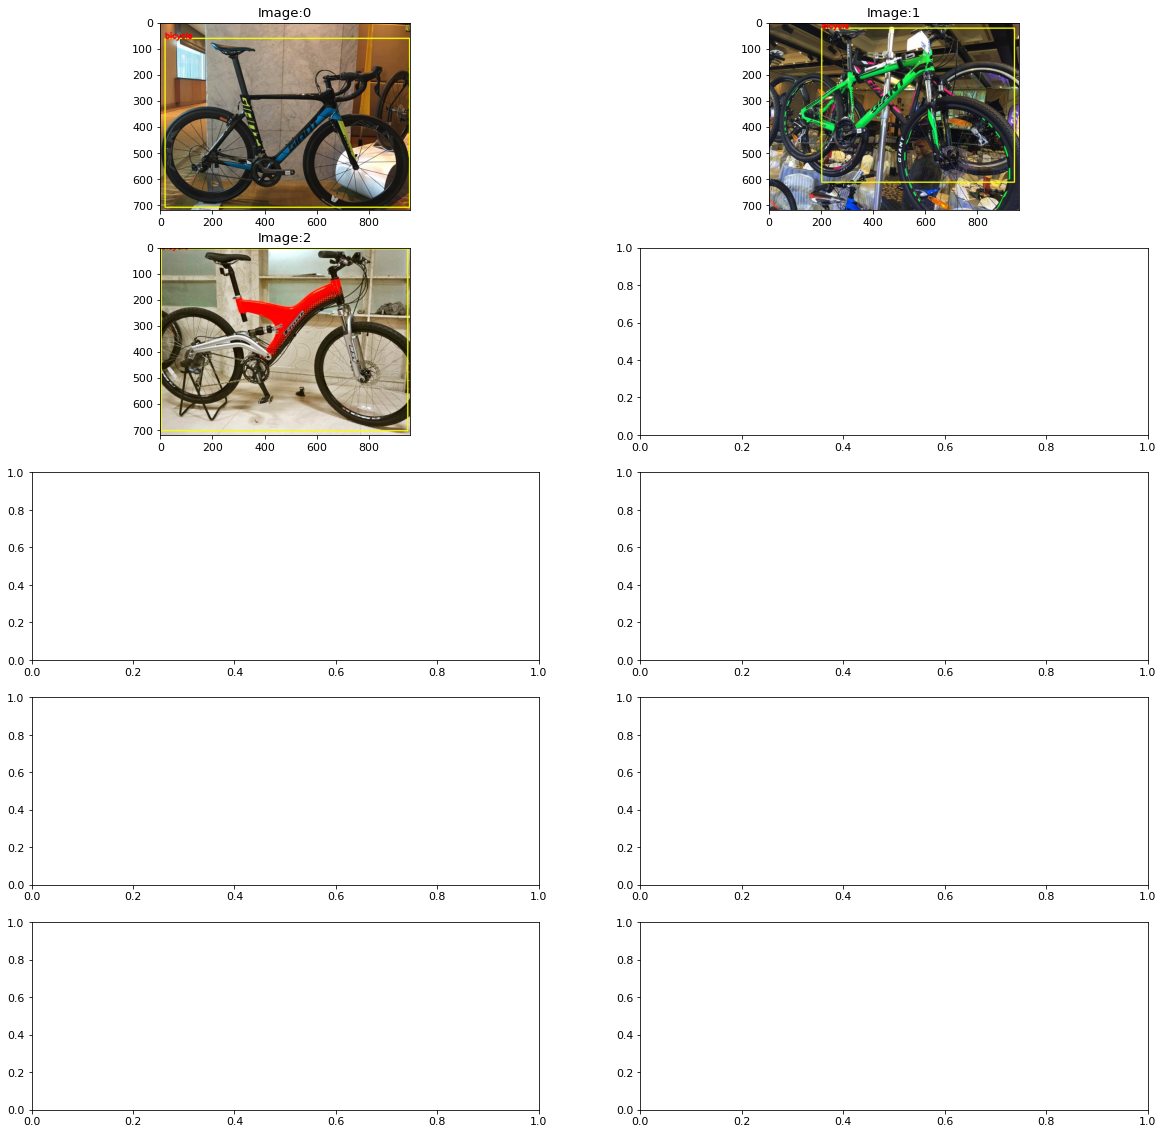

In [31]:
fig, axes = plt.subplots(5,2, figsize=(20,20))
axis_iter = iter(axes.ravel())
gts = []

for idx, (image_path, pascal_path) in enumerate(zip(images, pascal_files)):
    data_gt = obj.get_coordinates(image_path, pascal_path)
    img = obj.draw_bboxes(data_gt)
    
    for gt in data_gt:
        gts.append([idx] + gt)
        
    ax = next(axis_iter)
    ax.imshow(img)
    ax.set_title('Image:'+str(idx))

In [32]:
gts

[[0, 2, 19, 62, 958, 709], [1, 2, 202, 23, 942, 613], [2, 2, 4, 6, 951, 703]]

### Load models

In [33]:
def load_model(model_name):
    base_url = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/'
    model_file = model_name + '.tar.gz'
    model_dir = tf.keras.utils.get_file(
        fname=model_name, 
        origin=base_url + model_file,
        untar=True)

    model_dir = pathlib.Path(model_dir)/"saved_model"

    model = tf.saved_model.load(str(model_dir))
    print(str(model_dir))
    
    return model

### Load FasterRCNN & SSD models

In [34]:
'''
Reference:-
https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md
'''

# Load FasterRCNN model
model_name = 'faster_rcnn_resnet50_v1_640x640_coco17_tpu-8'
fasterRCNN_model = load_model(model_name)

# Load SSD model
model_name = 'ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8'
SSD_model = load_model(model_name)

C:\Users\Pc-Klinik\.keras\datasets\faster_rcnn_resnet50_v1_640x640_coco17_tpu-8\saved_model
C:\Users\Pc-Klinik\.keras\datasets\ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8\saved_model


### Inference functions

In [35]:
def run_inference_for_single_image(model, image):
    image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
    model_fn = model.signatures['serving_default']
    output_dict = model_fn(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
    num_detections = int(output_dict.pop('num_detections'))
    output_dict = {key:value[0, :num_detections].numpy() for key,value in output_dict.items()}
    output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
    if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                output_dict['detection_masks'], output_dict['detection_boxes'],
                image.shape[0], image.shape[1])      
        detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
        output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
    return output_dict

In [36]:
def show_inference(model, image_np):

  # Actual detection.
    output_dict = run_inference_for_single_image(model, image_np)
    
    classes, boxes, scores = [], [], []
    
    for i, x in enumerate(output_dict['detection_classes']):
        if (x == pascal_class_dict['car'] or x == pascal_class_dict['truck']) and output_dict['detection_scores'][i] > 0.5:
                
            classes.append(x)
            boxes.append(output_dict['detection_boxes'][i])
            scores.append(output_dict['detection_scores'][i])
    
    output_dict['detection_classes'] = np.array(classes)
    output_dict['detection_scores'] = np.array(scores)
    output_dict['detection_boxes'] = np.array(boxes)
    
        
  # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8,
      min_score_thresh=0.50
    )
    
    return image_np, output_dict

In [37]:
def get_bboxes(image, normalized_coordinates):
    im_height, im_width, _ = image.shape
    xmin, ymin, xmax, ymax = normalized_coordinates
    
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
    
    return int(left), int(top), int(right), int(bottom)

### Vizualize Predicted (FasterRCNN) Bounding boxes

StopIteration: 

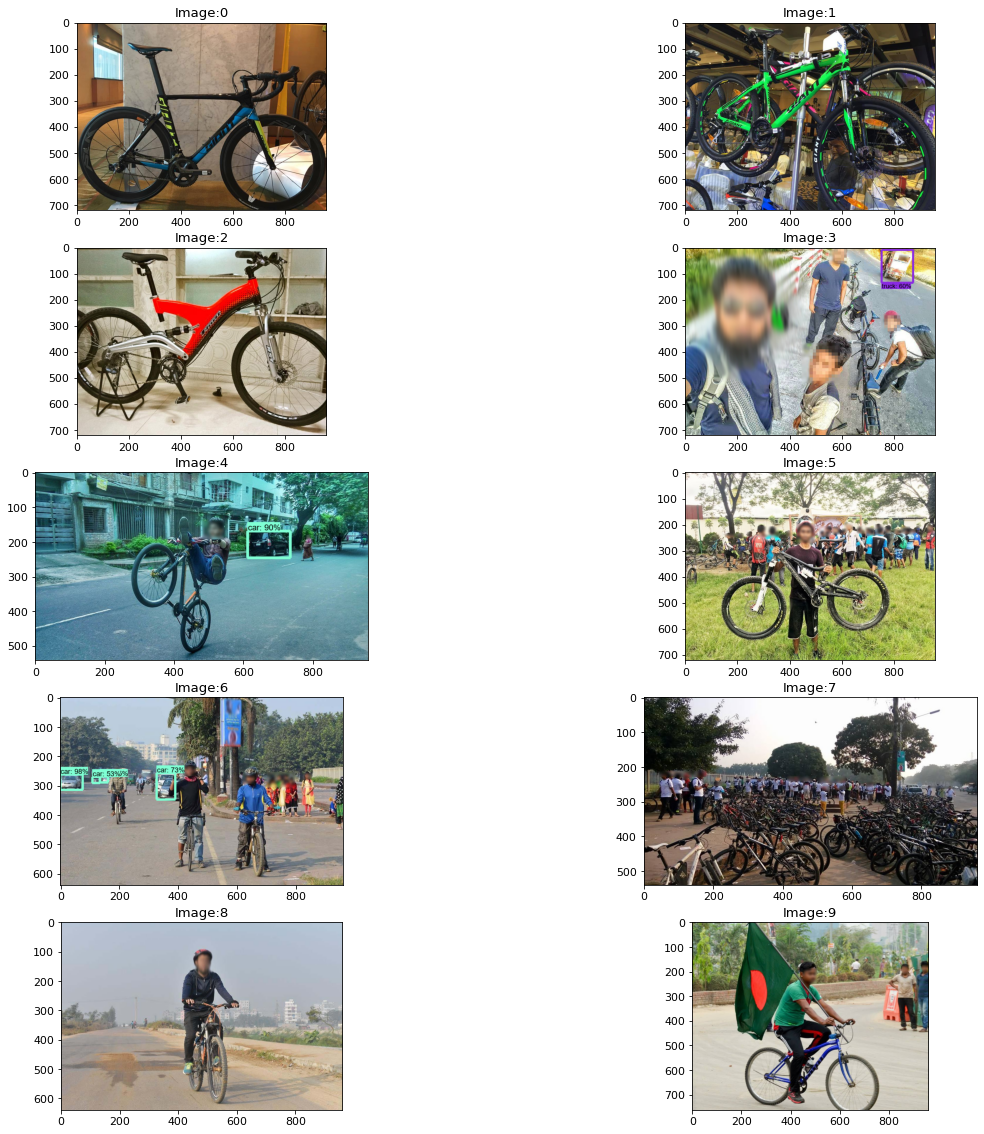

In [38]:
model = fasterRCNN_model


fig, axes = plt.subplots(5,2, figsize=(20,20))
axis_iter = iter(axes.ravel())

frcnn_preds = []

for idx, (image_path, pascal_path) in enumerate(zip(images, pascal_files)):
    img = obj.read_image(image_path)
    
    output_img, output_dict  = show_inference(model, img)
    
    for label, score, bboxes in zip(
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      output_dict['detection_boxes']
    ):
        x1, y1, x2, y2 = get_bboxes(img, bboxes)
        frcnn_preds.append([idx, label, score] + [x1, y1, x2, y2])
        
    ax = next(axis_iter)
    ax.imshow(img)
    ax.set_title('Image:'+str(idx))

In [39]:
frcnn_preds

[[3, 8, 0.598224, 14, 565, 182, 657],
 [4, 3, 0.897597, 303, 345, 436, 415],
 [6, 3, 0.9752035, 396, 0, 472, 51],
 [6, 3, 0.73386693, 389, 217, 523, 259],
 [6, 3, 0.54553086, 407, 89, 435, 108],
 [6, 3, 0.5293969, 408, 72, 438, 90]]

### Calculate mAP @ 0.5:0.05:0.95  (Faster RCNN)

In [37]:
'''
https://datascience.stackexchange.com/questions/16797/what-does-the-notation-map-5-95-mean

mAP@[0.5:0.05:95] -> iou_thresholds = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
'''

frcnn_mAPs = []
iou_thresholds = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
for iou_threshold in iou_thresholds:
    mAP = mean_average_precision(gts,
                                 frcnn_preds,
                                 iou_threshold=iou_threshold,
                                 classes=[pascal_class_dict['car'], pascal_class_dict['truck']])
    frcnn_mAPs.append(mAP)
    
frcnn_mAP_dict = get_mAP_dict(frcnn_mAPs)
frcnn_mAP_dict

{'mAP_0.5': 0.14561551482926288,
 'mAP_0.55': 0.14561551482926288,
 'mAP_0.6': 0.13996198480595873,
 'mAP_0.65': 0.12354986111084425,
 'mAP_0.7': 0.11942620022578103,
 'mAP_0.75': 0.11942620022578103,
 'mAP_0.8': 0.11942620022578103,
 'mAP_0.85': 0.11942620022578103,
 'mAP_0.9': 0.11138519036309687,
 'mAP_0.95': 0.09891677023647472,
 'mAP_average': 0.12427496370780244}

### Vizualize Predicted (SSD) Bounding boxes

StopIteration: 

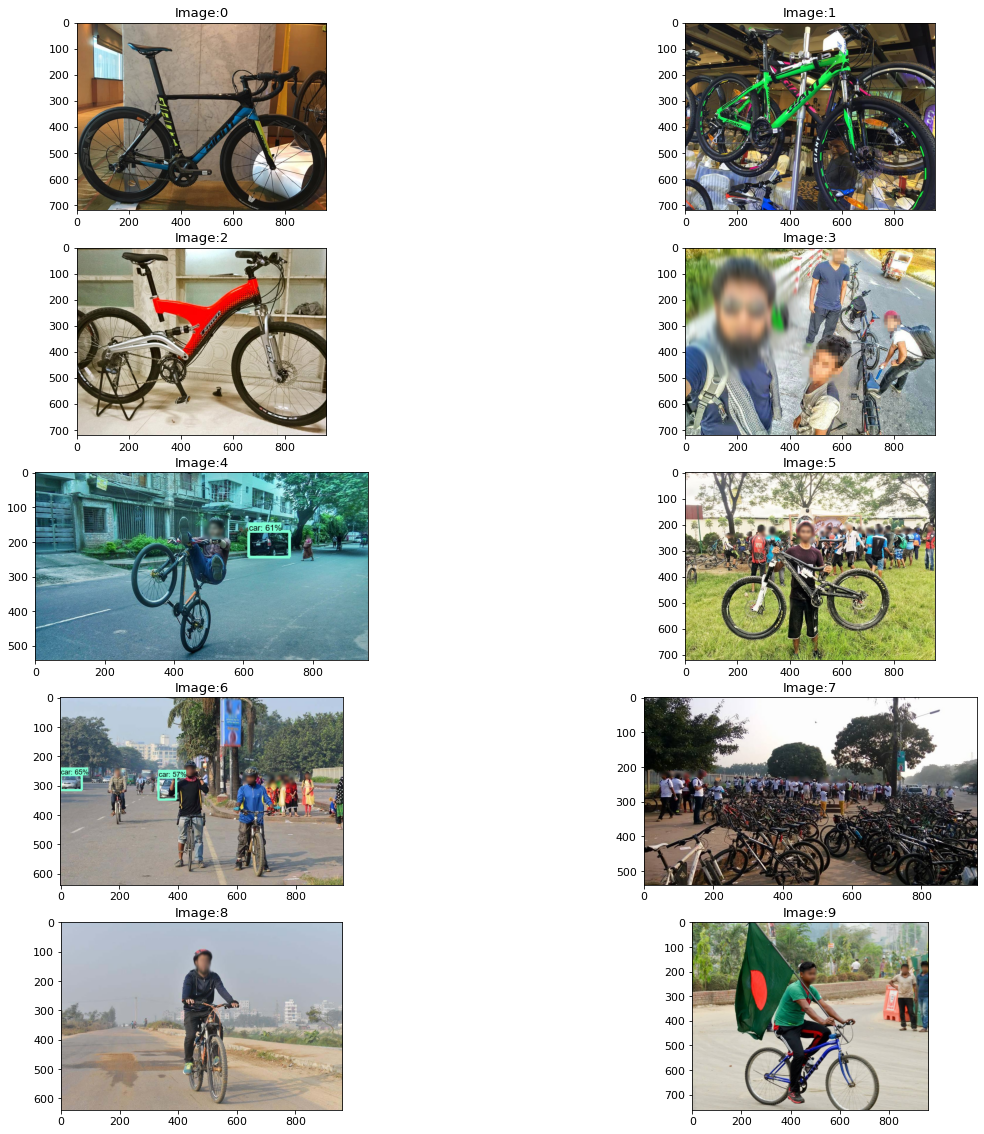

In [40]:
model = SSD_model


fig, axes = plt.subplots(5,2, figsize=(20,20))
axis_iter = iter(axes.ravel())

ssd_preds = []

for idx, (image_path, pascal_path) in enumerate(zip(images, pascal_files)):
    img = obj.read_image(image_path)
    
    output_img, output_dict  = show_inference(model, img)
    
    for label, score, bboxes in zip(
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      output_dict['detection_boxes']
    ):
        x1, y1, x2, y2 = get_bboxes(img, bboxes)
        ssd_preds.append([idx, label, score] + [x1, y1, x2, y2])
        
    ax = next(axis_iter)
    ax.imshow(img)
    ax.set_title('Image:'+str(idx))

In [41]:
ssd_preds

[[4, 3, 0.610325, 303, 346, 434, 414],
 [6, 3, 0.65344065, 399, 1, 474, 49],
 [6, 3, 0.5670443, 410, 221, 523, 262]]

### Calculate mAP @ 0.5:0.05:0.95 (SSD RCNN)

In [40]:
'''
https://datascience.stackexchange.com/questions/16797/what-does-the-notation-map-5-95-mean

mAP@[0.5:0.05:95] -> iou_thresholds = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
'''

ssd_mAPs = []
iou_thresholds = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
for iou_threshold in iou_thresholds:
    mAP = mean_average_precision(gts,
                                 ssd_preds,
                                 iou_threshold=iou_threshold,
                                 classes=[pascal_class_dict['car'], pascal_class_dict['truck']])
    ssd_mAPs.append(mAP)

ssd_mAP_dict = get_mAP_dict(ssd_mAPs)
ssd_mAP_dict

{'mAP_0.5': 0.20019060296880603,
 'mAP_0.55': 0.18830580330464777,
 'mAP_0.6': 0.18317074381515916,
 'mAP_0.65': 0.16779167161716824,
 'mAP_0.7': 0.16271859058367805,
 'mAP_0.75': 0.14050473908200517,
 'mAP_0.8': 0.13012688941761777,
 'mAP_0.85': 0.12553727713324542,
 'mAP_0.9': 0.12553727713324542,
 'mAP_0.95': 0.12553727713324542,
 'mAP_average': 0.15494208721888186}